In [2]:
import numpy as np
from astropy.cosmology import FlatLambdaCDM, Flatw0waCDM
from sympy.abc import alpha
from sympy.printing.pretty.pretty_symbology import line_width

from wowadis_muilt import run_cosmological_distances_multiprocessing,dh_inmpc,bao_dv_distance,bao_dv_dr,bao_fap,sne_luminosity_distance,log_likelihood, dm_inmpc,sne_distmod, run_lcdm_om0_by_multiprocessing,run_lcdm_methods_om0_by_multiprocessing, run_gaussian_methods_om0_by_multiprocessing, calculate_om0_distributions, run_mcmc
from scipy.optimize import minimize
import emcee
import matplotlib.pyplot as plt
import corner
import pandas as pd
from scipy.spatial import KDTree
import astropy.units as u
from scipy.stats import gaussian_kde
import gzip

data = np.genfromtxt('data/DES-SN5YR_HD.csv',
                     delimiter=',', names=True, dtype=None, encoding='utf-8')
zHEL_array = data['zHEL']
MUERR_FINAL_array = data['MUERR_FINAL']

with gzip.open('data/STAT+SYS.txt.gz', 'rt') as f:
    data = np.loadtxt(f, skiprows=1)
print("Data shape before reshape:", data.shape)

C_SYS = data.reshape((1829, 1829))
print("C_SYS shape after reshape:", C_SYS.shape)
cov_matrix_sne = np.diag(MUERR_FINAL_array ** 2) + C_SYS


print(zHEL_array)
print(MUERR_FINAL_array)
z_desy5 = np.array(zHEL_array)
des_sne_cosmo_wowa = Flatw0waCDM(H0=70, Om0=0.495, w0=-0.36, wa=-8.8)
distmod_error_desy5 = np.array(MUERR_FINAL_array)
#sne_distmod
des_distmod_compare_desy5 = sne_distmod(z=z_desy5, H0=70, Om0=0.495, w0=-0.36, wa=-8.8, cosmo=des_sne_cosmo_wowa)
# from paper:
zeff = np.array([0.295, 0.510, 0.706, 0.930, 1.317, 1.491, 2.330])
dm_rd = np.array([0, 13.62, 16.85, 21.71, 27.79, 0, 39.71])
delta_dm_rd = np.array([0, 0.25, 0.32, 0.28, 0.69, 0, 0.94])
dh_rd = np.array([0, 20.98, 20.08, 17.88, 13.82, 0, 8.52])
delta_dh_rd =np.array( [0, 0.61, 0.60, 0.35, 0.42, 0, 0.17])
dv_rd =np.array([7.93, -0.445, -0.420, -0.389, -0.444, 26.07, -0.447])
delata_dv_rd = [0.15, None, None, None, None, 0.67,None]
rdrag = 147.18 * u.Mpc
coefficient_r= np.array([np.nan, -0.445, -0.420, -0.389, -0.444, np.nan, -0.447])

def delta_ab(delta_a, delta_b, r):
    _delta_a= np.nan_to_num(delta_a, nan=0.0)
    _delta_b= np.nan_to_num(delta_b, nan=0.0)
    _r= np.nan_to_num(np.array(r), nan=0.0)
    return _r*_delta_a*_delta_b

def from_data_to_dvmet(z,dm_rd,dh_rd):
    dm_rd = np.array(dm_rd)
    dh_rd = np.array(dh_rd)
    z = np.array(z)
    dm = dm_rd
    dh = dh_rd
    dv = ((dm ** 2) * dh * (z)) ** (1 / 3)
    return dv

def from_data_to_fap(z,dm_rd,dh_rd):
    dm = dm_rd * 147.18
    dh = dh_rd * 147.18
    fap = (dm / dh)
    return fap

def delta_DV(z, delta_DM, delta_DH, DM, DH, coefficient):
    #DV = ((DM ** 2) * DH * (z)) ** (1 / 3)
    partial_DM = (2 * DM * DH * z) / (3 * (DM**2 * DH * z)**(2/3))
    partial_DH = (DM**2 * z) / (3 * (DM**2 * DH * z)**(2/3))
    _partial_DM = np.nan_to_num(partial_DM, nan=0.0)
    _partial_DH = np.nan_to_num(partial_DH, nan=0.0)
    _delta_DM = np.nan_to_num(delta_DM, nan=0.0)
    _delta_DH = np.nan_to_num(delta_DH, nan=0.0)
    covariance_term = delta_ab(_partial_DM* _delta_DM, _partial_DH * _delta_DH, coefficient)

    sigma_DV = np.sqrt((partial_DM * delta_DM)**2 + (partial_DH * delta_DH)**2+ 2 * covariance_term)
    return sigma_DV

def delta_FAP(delta_DM, delta_DH, DM, DH, coefficient):
    FAP = (DM / DH)
    coefficient = np.nan_to_num(coefficient, nan=0.0)

    covariance_term = delta_ab((delta_DM / DH), (DM * delta_DH / (DH**2)), coefficient)

    sigma_FAP = np.sqrt((delta_DM / DH)**2 + ((DM * delta_DH) / (DH**2))**2 - 2* covariance_term)
    return sigma_FAP

dv = from_data_to_dvmet(zeff,dm_rd,dh_rd)
print('dv',dv)

delta_DV(zeff, delta_dm_rd, delta_dh_rd, dm_rd, dh_rd, coefficient_r)
print('delta dv',delta_DV(zeff, delta_dm_rd, delta_dh_rd, dm_rd, dh_rd, coefficient_r))

zeff_array = np.array([0.295, 0.510, 0.706, 0.930, 1.317, 1.491, 2.330])
_compare_cosmo_bao = FlatLambdaCDM(H0=70, Om0=0.3)
_dv_dr_compare = bao_dv_dr(zeff_array, H0=70, Om0=0.3, w0=-1.0, wa=0)

_dh_dr_compare  = dh_inmpc(zeff_array, H0=70, Om0=0.3, w0=-1.0, wa=0).value/147.18
_dm_dr_compare  = dm_inmpc(zeff_array, H0=70, Om0=0.3, w0=-1.0, wa=0).value/147.18

print(((_dh_dr_compare)*((_dm_dr_compare**2)*zeff_array))**(1/3))
print(_dv_dr_compare)
delta_dv_imcom = delta_DV(zeff, delta_dm_rd, delta_dh_rd, _dm_dr_compare, _dh_dr_compare, coefficient_r)
print(delta_dv_imcom) #incomplete
delta_dv = delta_dv_imcom
delta_dv[0] = 0.15  #same as in table1 of desi paper
delta_dv[5] = 0.67
print(delta_dv)
zeff_fap = np.delete(zeff_array, [0, 5])
_fap_compare = bao_fap(zeff_fap, H0=70, Om0=0.3, w0=-1.0, wa=0)
print(_fap_compare)
#(delta_DM, delta_DH, DM, DH)
delta_fap_imcom = delta_FAP(delta_dm_rd, delta_dh_rd, _dm_dr_compare, _dh_dr_compare, coefficient_r)
print(delta_fap_imcom)
delta_fap = np.delete(delta_fap_imcom, [0, 5])
print(delta_fap)
#bao part:
print(zeff_array)
print(delta_dv)

print('zeff_fap',zeff_fap)
print(delta_fap)

#SNe part:
print(z_desy5)
print(distmod_error_desy5)

print('xxxxxxxxxxxxX')

file_path = 'data/fw0wacdm_SN_emcee.txt'
data_SN = pd.read_csv(file_path, sep='\s+', comment='#', header=None)
data_SN.columns = ['omega_m', 'w', 'wa', 'prior', 'post']
data_subset_SN = data_SN[['w', 'wa', 'omega_m']]
param_combinations_desy5 = data_subset_SN.to_numpy()

H0_column_sn_desy5 = np.full((param_combinations_desy5.shape[0], 1), 70.0)

param_combinations_desy5 = np.hstack((param_combinations_desy5,H0_column_sn_desy5))

if len(param_combinations_desy5) >= 20000:
    # Randomly select 20,000 rows
    random_indices = np.random.choice(param_combinations_desy5.shape[0], 4000, replace=False)
    lw_params = param_combinations_desy5[random_indices]

file_path_2 = 'data/fw0wacdm_planck+SN+eBOSS+3x2pt.txt'
data_sn_bao_cmb = pd.read_csv(file_path_2, sep='\s+', comment='#', header=None)
column_names_bao_cmb = [
    'omega_m', 'h0', 'omega_b', 'n_s', 'a_s', 'w', 'wa', 'mnu', 'tau',
    'shear_calibration_m1', 'shear_calibration_m2', 'shear_calibration_m3', 'shear_calibration_m4',
    'wl_photoz_bias_1', 'wl_photoz_bias_2', 'wl_photoz_bias_3', 'wl_photoz_bias_4',
    'lens_photoz_bias_1', 'lens_photoz_bias_2', 'lens_photoz_bias_3', 'lens_photoz_bias_4',
    'lens_photoz_width_1', 'lens_photoz_width_2', 'lens_photoz_width_3', 'lens_photoz_width_4',
    'bias_lens_b1', 'bias_lens_b2', 'bias_lens_b3', 'bias_lens_b4',
    'intrinsic_alignment_a1', 'intrinsic_alignment_a2', 'intrinsic_alignment_alpha1', 'intrinsic_alignment_alpha2',
    'intrinsic_alignment_bias_ta', 'prior', 'like', 'post', 'weight'
]
data_sn_bao_cmb.columns = column_names_bao_cmb
data_sn_bao_cmb = data_sn_bao_cmb[['w', 'wa', 'omega_m','h0']]
data_sn_bao_cmb['h0'] = data_sn_bao_cmb['h0'] * 100
param_combinations_sn_bao_cmb = data_sn_bao_cmb.to_numpy()

random_indices_sbc = np.random.choice(param_combinations_sn_bao_cmb.shape[0], 10000, replace=False)
lw_params_sn_bao_cmb = param_combinations_sn_bao_cmb[random_indices_sbc]

z_all = {'sne': z_desy5, 'dv': zeff_array, 'fap': zeff_fap}
data_err_all = {'sne': distmod_error_desy5, 'dv': delta_dv, 'fap': delta_fap}
#cov_matrix_sne

Data shape before reshape: (3345241,)
C_SYS shape after reshape: (1829, 1829)
[0.24651 0.336   0.38388 ... 0.02561 0.02448 0.092  ]
[0.0968 0.136  0.2332 ... 0.1237 0.116  0.2873]
dv [ 0.         12.56733789 15.90704123 19.86354247 24.13368485  0.
 31.51604873]
delta dv [       nan 0.14769734 0.19712699 0.1695468  0.36418021        nan
 0.44508433]
[ 7.78277361 12.43113123 15.97929259 19.34675898 23.81612642 25.39850208
 30.66427324]
[ 7.83003238 12.50661589 16.0763225  19.46423691 23.96074337 25.55272757
 30.8504737 ]
[0.         0.14870767 0.19699585 0.16942324 0.36576218 0.
 0.45039171]
[0.15       0.14870767 0.19699585 0.16942324 0.36576218 0.67
 0.45039171]
[0.59053747 0.87174805 1.235266   1.97072542 4.5056629 ]
[0.         0.02361165 0.03654867 0.03482655 0.09344398 0.
 0.17147831]
[0.02361165 0.03654867 0.03482655 0.09344398 0.17147831]
[0.295 0.51  0.706 0.93  1.317 1.491 2.33 ]
[0.15       0.14870767 0.19699585 0.16942324 0.36576218 0.67
 0.45039171]
zeff_fap [0.51  0.706 0.9

/var/folders/2d/zqs_vr2n65q9fsqw5kq8wmqw0000gn/T/ipykernel_27726/2688914837.py:72: RuntimeWarning: invalid value encountered in divide
  partial_DM = (2 * DM * DH * z) / (3 * (DM**2 * DH * z)**(2/3))
/var/folders/2d/zqs_vr2n65q9fsqw5kq8wmqw0000gn/T/ipykernel_27726/2688914837.py:73: RuntimeWarning: invalid value encountered in divide
  partial_DH = (DM**2 * z) / (3 * (DM**2 * DH * z)**(2/3))


In [3]:
import numpy as np

bins = np.arange(-0.05, max(z_desy5) + 0.15, 0.15)
bin_centers = 0.5 * (bins[1:] + bins[:-1])

bin_indices = np.digitize(z_desy5, bins) - 1

binned_means = []
binned_errors = []

for i in range(len(bins) - 1):
    in_bin = bin_indices == i
    if np.any(in_bin):
        errors_in_bin = distmod_error_desy5[in_bin]

        weights = 1 / errors_in_bin**2
        weighted_error = np.sqrt(1 / np.sum(weights))


        binned_errors.append(weighted_error)

bin_centers, binned_errors

(array([0.025, 0.175, 0.325, 0.475, 0.625, 0.775, 0.925, 1.075]),
 [0.007769951226327119,
  0.012585594579134836,
  0.007826097637476619,
  0.008166994605986603,
  0.007842146914774882,
  0.013169870782519936,
  0.025341071932228,
  0.04066091786510664])

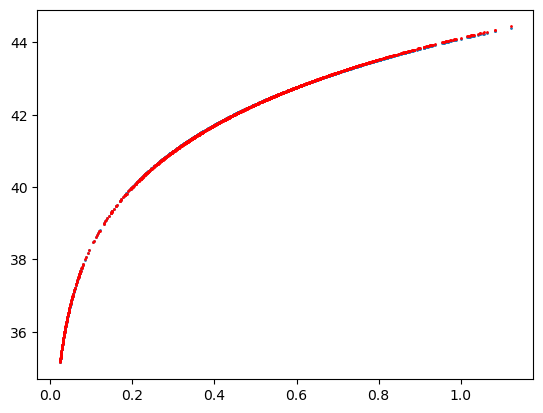

In [4]:
binned_errors = np.array(binned_errors)
z_continous_sne = np.linspace(min(z_desy5), max(z_desy5), 3000)
_sne_distmod_under_lcdm = sne_distmod(z=z_desy5, H0=67.88, Om0=0.35, w0=-1, wa=0)
_sne_distmod_under_planck_lcdm = sne_distmod(z=z_desy5, H0=68.55, Om0=0.315, w0=-1, wa=0)
_sne_distmod_under_w0wa = sne_distmod(z=z_desy5,  H0=67.24, Om0= 0.316, w0=-0.727, wa=-1.05)

_sne_distmod_under_lcdm_continuous = sne_distmod(z=z_continous_sne, H0=67.88, Om0=0.35, w0=-1, wa=0)
_sne_distmod_under_planck_lcdm_continuous = sne_distmod(z=z_continous_sne, H0=68.55, Om0=0.315, w0=-1, wa=0)
_sne_distmod_under_w0wa_continuous = sne_distmod(z=z_continous_sne, H0=67.24, Om0=0.316, w0=-0.727, wa=-1.05)


fig, ax = plt.subplots()
ax.scatter(z_desy5, _sne_distmod_under_lcdm, s=1)
ax.scatter(z_desy5, _sne_distmod_under_w0wa, color='red',s = 1)

def chi2(delta_E):
    # Calculate chi-squared using the covariance matrix
    chi2 = delta_E.T @ np.linalg.solve(cov_matrix_sne, delta_E)
    # Calculate log-likelihood
    return chi2


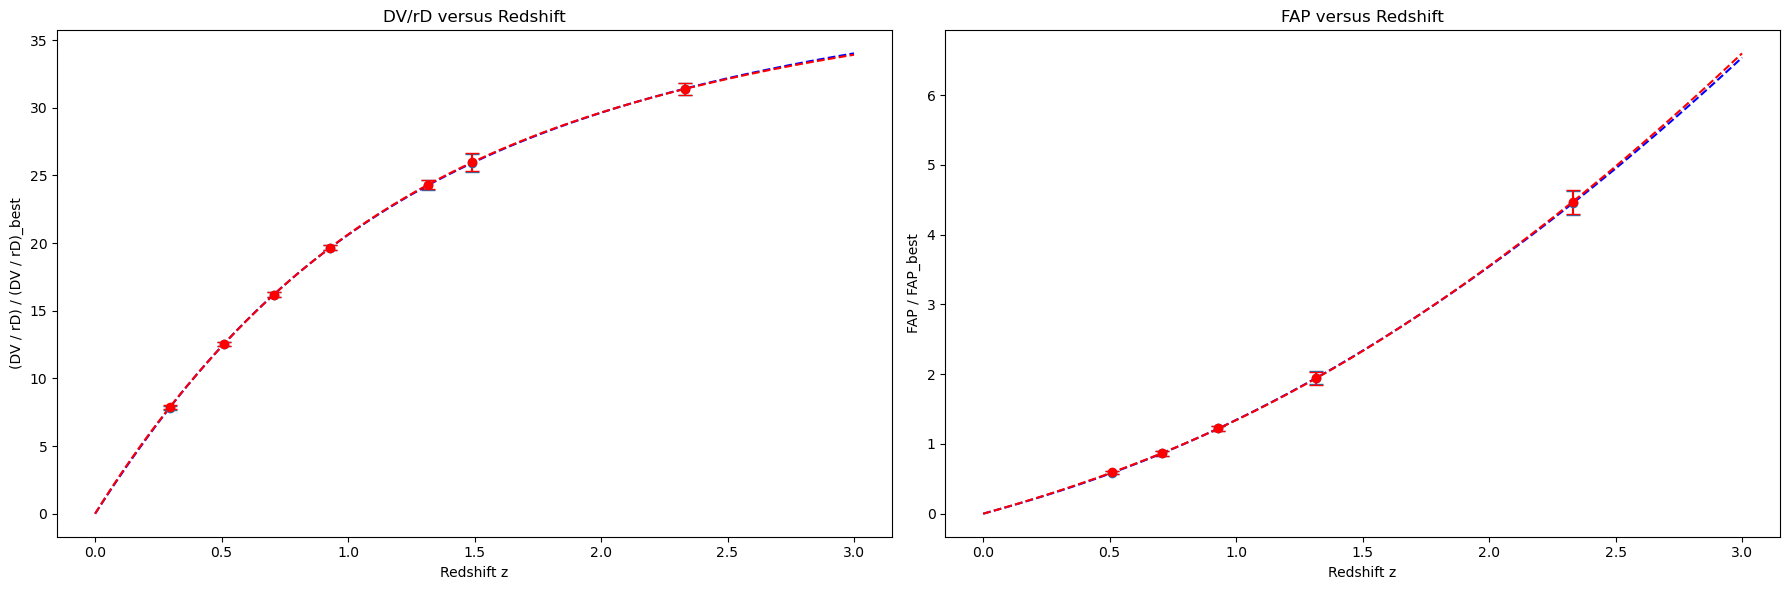

In [5]:
z_0to3=np.linspace(0.0001,3,3000)
#_sne_distmod_under_w0wa = sne_distmod(z=z_desy5, H0=70, Om0=0.32, w0=-0.85, wa=-0.58)
omm_lcdm = 0.28
omm_lcdm2= 0.315
omm_waw0 = 0.316
waw0_wa=-1.05
waw0_w0=-0.727
h0_w0wa =67.24#67.24
h0_295 =68.6# 69.72
h0_315 =68.82 #69.72

zeff_array_continuous = np.linspace(min(zeff_array), max(zeff_array), 3000)
zeff_fap_continuous = np.linspace(0.25, max(zeff_fap), 3000)

_dv_dr_compare = bao_dv_dr(zeff_array, H0=h0_295, Om0=omm_lcdm, w0=-1.0, wa=0)
_fap_compare = bao_fap(zeff_fap, H0=h0_295, Om0=omm_lcdm, w0=-1.0, wa=0)

_dv_dr_compare_continuous = bao_dv_dr(zeff_array_continuous, H0=h0_295, Om0=omm_lcdm, w0=-1.0, wa=0)
_fap_compare_continuous = bao_fap(zeff_fap_continuous, H0=h0_295, Om0=omm_lcdm, w0=-1.0, wa=0)

_dv_dr_compare_0315 = bao_dv_dr(zeff_array, H0=h0_315, Om0=omm_lcdm2, w0=-1.0, wa=0)
_fap_compare_0315 = bao_fap(zeff_fap, H0=h0_315, Om0=omm_lcdm2, w0=-1.0, wa=0)

_dv_dr_compare_0315_continuous = bao_dv_dr(zeff_array_continuous, H0=h0_315, Om0=omm_lcdm2, w0=-1.0, wa=0)
_fap_compare_0315_continuous = bao_fap(zeff_fap_continuous, H0=h0_315, Om0=omm_lcdm2, w0=-1.0, wa=0)

_dv_dr_compare_h0_different= bao_dv_dr(zeff_array, H0=67.5, Om0=0.27986, w0=-1.0, wa=0)
_fap_compare_h0_different = bao_fap(zeff_fap, H0=67.5, Om0=0.27986, w0=-1.0, wa=0)

_dv_dr_compare_h0_different_continuous = bao_dv_dr(zeff_array_continuous, H0=67.5, Om0=0.27986, w0=-1.0, wa=0)
_fap_compare_h0_different_continuous = bao_fap(zeff_fap_continuous, H0=67.5, Om0=0.27986, w0=-1.0, wa=0)

_dv_dr_compare_w0wa = bao_dv_dr(zeff_array, H0=h0_w0wa, Om0=omm_waw0, w0=waw0_w0, wa=waw0_wa)
_fap_compare_w0wa = bao_fap(zeff_fap, H0=h0_w0wa, Om0=omm_waw0, w0=waw0_w0, wa=waw0_wa)

_dv_dr_compare_w0wa_continuous = bao_dv_dr(zeff_array_continuous, H0=h0_w0wa, Om0=omm_waw0, w0=waw0_w0, wa=waw0_wa)
_fap_compare_w0wa_continuous = bao_fap(zeff_fap_continuous, H0=h0_w0wa, Om0=omm_waw0, w0=waw0_w0, wa=waw0_wa)

_dv_dr_z_0to3_lcdm = bao_dv_dr(z_0to3, H0=h0_295, Om0=omm_lcdm, w0=-1.0, wa=0)
_dv_dr_z_0to3_w0wa = bao_dv_dr(z_0to3, H0=h0_w0wa, Om0=omm_waw0, w0=waw0_w0, wa=waw0_wa)

_fap_compare_0to3_lcdm = bao_fap(z_0to3, H0=h0_295, Om0=omm_lcdm, w0=-1.0, wa=0)
_fap_compare_0to3_w0wa = bao_fap(z_0to3, H0=h0_w0wa, Om0=omm_waw0, w0=waw0_w0, wa=waw0_wa)

fig, axs = plt.subplots(1, 2, figsize=(18, 6))

axs[0].errorbar(zeff_array, _dv_dr_compare, yerr=delta_dv, fmt='o', capsize=5)
axs[0].errorbar(zeff_array, _dv_dr_compare_w0wa, yerr=delta_dv, fmt='o', capsize=5, color='red')
axs[0].plot(z_0to3, _dv_dr_z_0to3_lcdm, color='blue',ls='--')
axs[0].plot(z_0to3, _dv_dr_z_0to3_w0wa, color='red',ls='--')
#axs[0].plot(zeff_array, np.ones_like(zeff_array), 'k--')
#axs[0].fill_between(zeff_array, (_dv_dr_compare - delta_dv)/_dv_dr_compare, (_dv_dr_compare + delta_dv)/_dv_dr_compare, color='gray', alpha=0.2)
axs[0].set_xlabel('Redshift z')
axs[0].set_ylabel('(DV / rD) / (DV / rD)_best')
axs[0].set_title('DV/rD versus Redshift')

axs[1].errorbar(zeff_fap, _fap_compare, yerr=delta_fap, fmt='o', capsize=5)
axs[1].errorbar(zeff_fap, _fap_compare_w0wa, yerr=delta_fap, fmt='o', capsize=5, color='red')
axs[1].plot(z_0to3, _fap_compare_0to3_lcdm, color='blue',ls='--')
axs[1].plot(z_0to3, _fap_compare_0to3_w0wa, color='red',ls='--')
#axs[1].plot(zeff_fap, np.ones_like(zeff_fap), 'k--')
#axs[1].fill_between(zeff_fap, (_fap_compare - delta_fap)/_fap_compare, (_fap_compare + delta_fap)/_fap_compare, color='gray', alpha=0.2)
axs[1].set_xlabel('Redshift z')
axs[1].set_ylabel('FAP / FAP_best')
axs[1].set_title('FAP versus Redshift')

plt.tight_layout()
plt.show()

In [7]:

def chi2_bao(delta_E_dv, delta_E_fap):
    chi2_dv = np.sum((delta_E_dv / delta_dv) ** 2)
    ln_L_dv = -0.5 * (chi2_dv + np.sum(np.log(2 * np.pi * delta_dv ** 2)))

    chi2_fap = np.sum((delta_E_fap / delta_fap) ** 2)
    ln_L_fap = -0.5 * (chi2_fap + np.sum(np.log(2 * np.pi * delta_fap ** 2)))

    chi2_total = chi2_dv + chi2_fap
    return chi2_total

chi2_bao_295 = chi2_bao(_dv_dr_compare-_dv_dr_compare_w0wa, _fap_compare-_fap_compare_w0wa)

chi2_bao_315 = chi2_bao(_dv_dr_compare_0315-_dv_dr_compare_w0wa, _fap_compare_0315-_fap_compare_w0wa)

chi2_bao_different_h0 = chi2_bao(_dv_dr_compare_h0_different-_dv_dr_compare_w0wa, _fap_compare_h0_different-_fap_compare_w0wa)

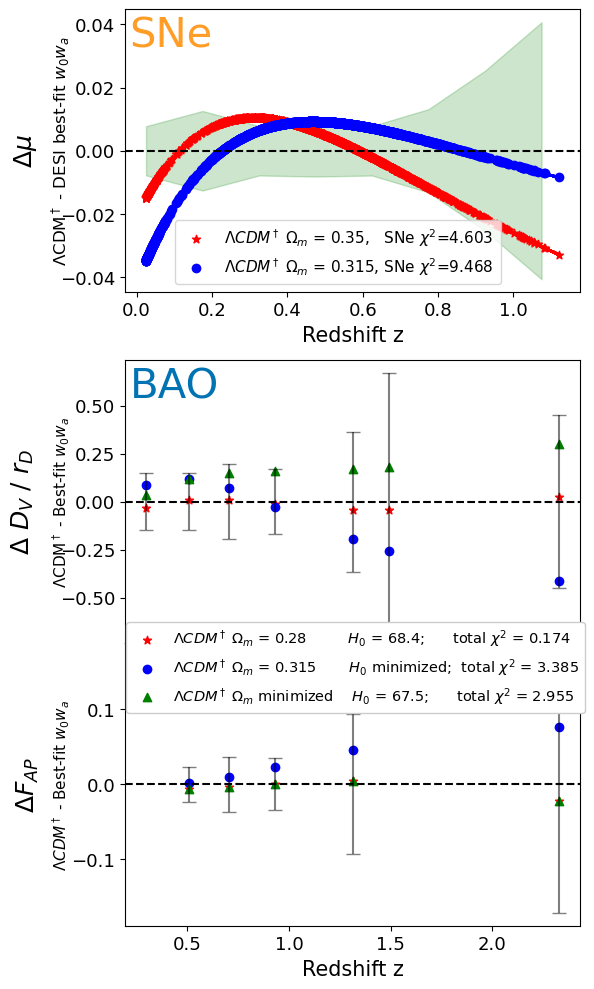

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.gridspec as gridspec


fig = plt.figure(figsize=(6, 10))

gs = gridspec.GridSpec(2, 1, height_ratios=[1, 2])

ax0 = fig.add_subplot(gs[0])

a = chi2(_sne_distmod_under_lcdm - _sne_distmod_under_w0wa)
b = chi2(_sne_distmod_under_planck_lcdm - _sne_distmod_under_w0wa)

ax0.axhline(y=0, color='black', linestyle='--')
ax0.fill_between(bin_centers, (binned_errors - binned_errors - binned_errors),
                 (binned_errors - binned_errors + binned_errors), color='green', alpha=0.2)
ax0.scatter(z_desy5, _sne_distmod_under_lcdm - _sne_distmod_under_w0wa, color='red',
            label=f"$\Lambda CDM$$^\dagger$ $\Omega_m$ = 0.35,   SNe $\chi^2$={a:.3f} ", marker='*')
ax0.scatter(z_continous_sne, _sne_distmod_under_lcdm_continuous - _sne_distmod_under_w0wa_continuous, color='red', s=1)
ax0.scatter(z_desy5, _sne_distmod_under_planck_lcdm - _sne_distmod_under_w0wa , color='blue',
            label=f'$\Lambda CDM$$^\dagger$ $\Omega_m$ = 0.315, SNe $\chi^2$={b:.3f}')
ax0.scatter(z_continous_sne, _sne_distmod_under_planck_lcdm_continuous - _sne_distmod_under_w0wa_continuous, color='blue', s=1)
ax0.set_xlabel("Redshift z", fontsize=15)
ax0.set_ylabel(r"$\Delta \mu$", fontsize=18,labelpad=15)
ax0.text(-0.14, 0.5, "$\Lambda$CDM$^\dagger$ - DESI best-fit $w_0w_a$",
         fontsize=12, transform=ax0.transAxes, ha='center', va='center', rotation='vertical')
ax0.tick_params(axis='x', labelsize=13)
ax0.tick_params(axis='y', labelsize=13)
ax0.grid(False)
ax0.legend(loc=(0.11, 0.03),fontsize=11)
ax0.text(
    -0.02, 0.033,
    "SNe",
    fontsize=30,
    ha='left',
    color='#ff9d27'
)


gs1 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[1], hspace=0)

ax1 = fig.add_subplot(gs1[0], sharex=None)
ax2 = fig.add_subplot(gs1[1], sharex=ax1)

plt.setp(ax1.get_xticklabels(), visible=False)

ax1.errorbar(zeff_array, _dv_dr_compare - _dv_dr_compare, yerr=delta_dv, fmt='none', capsize=5, alpha=0.5, color='black')
ax1.scatter(zeff_array, _dv_dr_compare - _dv_dr_compare_w0wa, color='red', marker='*')
ax1.scatter(zeff_array, _dv_dr_compare_0315 - _dv_dr_compare_w0wa, color='blue')
ax1.scatter(zeff_array, _dv_dr_compare_h0_different - _dv_dr_compare_w0wa, color='green',marker="^")
ax1.grid(False)
ax1.axhline(y=0, color='black', linestyle='--')

ax1.tick_params(axis='x', labelsize=13)
ax1.tick_params(axis='y', labelsize=13)
ax1.set_ylabel("$\Delta$ $D_V$ / $r_D$", fontsize=18,labelpad=17)
ax1.text(-0.14, 0.5, "$\Lambda$CDM$^\dagger$ - Best-fit $w_0w_a$",
         fontsize=11, transform=ax1.transAxes, ha='center', va='center', rotation='vertical')
ax1.text(
    0.22, 0.54,
    "BAO",
    fontsize=30,
    ha='left',
    color='#0173b2'
)
#ax1.legend()

ax2.errorbar(zeff_fap, _fap_compare - _fap_compare, yerr=delta_fap, fmt='none', capsize=5, alpha=0.5, color='black')
ax2.scatter(zeff_fap, _fap_compare - _fap_compare_w0wa, color='red',
            label=f'$\Lambda CDM$$^\dagger$ $\\Omega_m$ = 0.28         $H_0$ = 68.4;      total $\\chi^2$ = {chi2_bao_295:.3f}', marker='*')
ax2.scatter(zeff_fap, _fap_compare_0315 - _fap_compare_w0wa, color='blue',
            label=f'$\Lambda CDM$$^\dagger$ $\\Omega_m$ = 0.315       $H_0$ minimized;  total $\\chi^2$ = {chi2_bao_315:.3f}')
ax2.scatter(zeff_fap, _fap_compare_h0_different - _fap_compare_w0wa, color='green',
            label=f'$\Lambda CDM$$^\dagger$ $\\Omega_m$ minimized    $H_0$ = 67.5;      total $\\chi^2$ = {chi2_bao_different_h0:.3f}',marker="^")

ax2.tick_params(axis='x', labelsize=13)
ax2.tick_params(axis='y', labelsize=13)
ax2.set_xlabel("Redshift z", fontsize=15)
ax2.axhline(y=0, color='black', linestyle='--')

ax2.legend()
ax2.set_ylabel("$\Delta F_{AP}$", fontsize=18, labelpad=22)
ax2.text(-0.14, 0.5, "$\Lambda CDM$$^\dagger$ - Best-fit $w_0w_a$",
         fontsize=11, transform=ax2.transAxes, ha='center', va='center', rotation='vertical')

ax2.legend(loc='upper left', bbox_to_anchor=(-0.013, 1.1), framealpha=1,fontsize=10.5)

plt.grid(False)
plt.tight_layout()
plt.savefig('mu_fap_dv_lcdm_w0wabest.png', dpi=600)
plt.show()

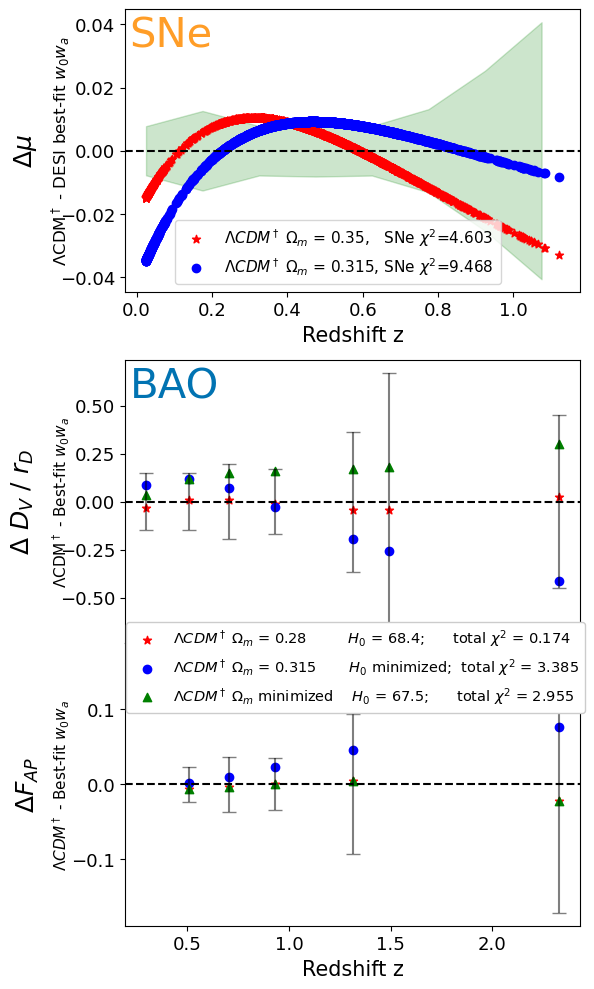

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(6, 10))

gs = gridspec.GridSpec(2, 1, height_ratios=[1, 2])

ax0 = fig.add_subplot(gs[0])

a = chi2(_sne_distmod_under_lcdm - _sne_distmod_under_w0wa)
b = chi2(_sne_distmod_under_planck_lcdm - _sne_distmod_under_w0wa)

ax0.axhline(y=0, color='black', linestyle='--')
ax0.fill_between(bin_centers, (binned_errors - binned_errors - binned_errors),
                 (binned_errors - binned_errors + binned_errors), color='green', alpha=0.2)
ax0.scatter(z_desy5, _sne_distmod_under_lcdm - _sne_distmod_under_w0wa, color='red',
            label=f"$\Lambda CDM$$^\dagger$ $\Omega_m$ = 0.35,   SNe $\chi^2$={a:.3f} ", marker='*')
ax0.scatter(z_desy5, _sne_distmod_under_planck_lcdm - _sne_distmod_under_w0wa , color='blue',
            label=f'$\Lambda CDM$$^\dagger$ $\Omega_m$ = 0.315, SNe $\chi^2$={b:.3f}')
ax0.set_xlabel("Redshift z", fontsize=15)
ax0.set_ylabel(r"$\Delta \mu$", fontsize=18,labelpad=15)
ax0.text(-0.14, 0.5, "$\Lambda$CDM$^\dagger$ - DESI best-fit $w_0w_a$",
         fontsize=12, transform=ax0.transAxes, ha='center', va='center', rotation='vertical')
ax0.tick_params(axis='x', labelsize=13)
ax0.tick_params(axis='y', labelsize=13)
ax0.grid(False)
ax0.legend(loc=(0.11, 0.03),fontsize=11)
ax0.text(
    -0.02, 0.033,
    "SNe",
    fontsize=30,
    ha='left',
    color='#ff9d27'
)


gs1 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[1], hspace=0)

ax1 = fig.add_subplot(gs1[0], sharex=None)
ax2 = fig.add_subplot(gs1[1], sharex=ax1)

plt.setp(ax1.get_xticklabels(), visible=False)

# Plotting on ax1 (DV / rD comparison)
ax1.errorbar(zeff_array, _dv_dr_compare - _dv_dr_compare, yerr=delta_dv, fmt='none', capsize=5, alpha=0.5, color='black')
ax1.scatter(zeff_array, _dv_dr_compare - _dv_dr_compare_w0wa, color='red', marker='*')
ax1.scatter(zeff_array, _dv_dr_compare_0315 - _dv_dr_compare_w0wa, color='blue')
ax1.scatter(zeff_array, _dv_dr_compare_h0_different - _dv_dr_compare_w0wa, color='green',marker="^")
ax1.grid(False)
ax1.axhline(y=0, color='black', linestyle='--')

ax1.tick_params(axis='x', labelsize=13)
ax1.tick_params(axis='y', labelsize=13)
ax1.set_ylabel("$\Delta$ $D_V$ / $r_D$", fontsize=18,labelpad=17)
ax1.text(-0.14, 0.5, "$\Lambda$CDM$^\dagger$ - Best-fit $w_0w_a$",
         fontsize=11, transform=ax1.transAxes, ha='center', va='center', rotation='vertical')
ax1.text(
    0.22, 0.54,
    "BAO",
    fontsize=30,
    ha='left',
    color='#0173b2'
)
#ax1.legend()

ax2.errorbar(zeff_fap, _fap_compare - _fap_compare, yerr=delta_fap, fmt='none', capsize=5, alpha=0.5, color='black')
ax2.scatter(zeff_fap, _fap_compare - _fap_compare_w0wa, color='red',
            label=f'$\Lambda CDM$$^\dagger$ $\\Omega_m$ = 0.28         $H_0$ = 68.4;      total $\\chi^2$ = {chi2_bao_295:.3f}', marker='*')
ax2.scatter(zeff_fap, _fap_compare_0315 - _fap_compare_w0wa, color='blue',
            label=f'$\Lambda CDM$$^\dagger$ $\\Omega_m$ = 0.315       $H_0$ minimized;  total $\\chi^2$ = {chi2_bao_315:.3f}')
ax2.scatter(zeff_fap, _fap_compare_h0_different - _fap_compare_w0wa, color='green',
            label=f'$\Lambda CDM$$^\dagger$ $\\Omega_m$ minimized    $H_0$ = 67.5;      total $\\chi^2$ = {chi2_bao_different_h0:.3f}',marker="^")

ax2.tick_params(axis='x', labelsize=13)
ax2.tick_params(axis='y', labelsize=13)
ax2.set_xlabel("Redshift z", fontsize=15)
ax2.axhline(y=0, color='black', linestyle='--')

ax2.legend()
ax2.set_ylabel("$\Delta F_{AP}$", fontsize=18, labelpad=22)
ax2.text(-0.14, 0.5, "$\Lambda CDM$$^\dagger$ - Best-fit $w_0w_a$",
         fontsize=11, transform=ax2.transAxes, ha='center', va='center', rotation='vertical')

ax2.legend(loc='upper left', bbox_to_anchor=(-0.013, 1.1), framealpha=1,fontsize=10.5)

plt.grid(False)
# Adjust layoutmu_fap_dv_lcdm_w0wabest
plt.tight_layout()
#plt.savefig('mu_fap_dv_lcdm_w0wabest.png', dpi=600)
plt.show()


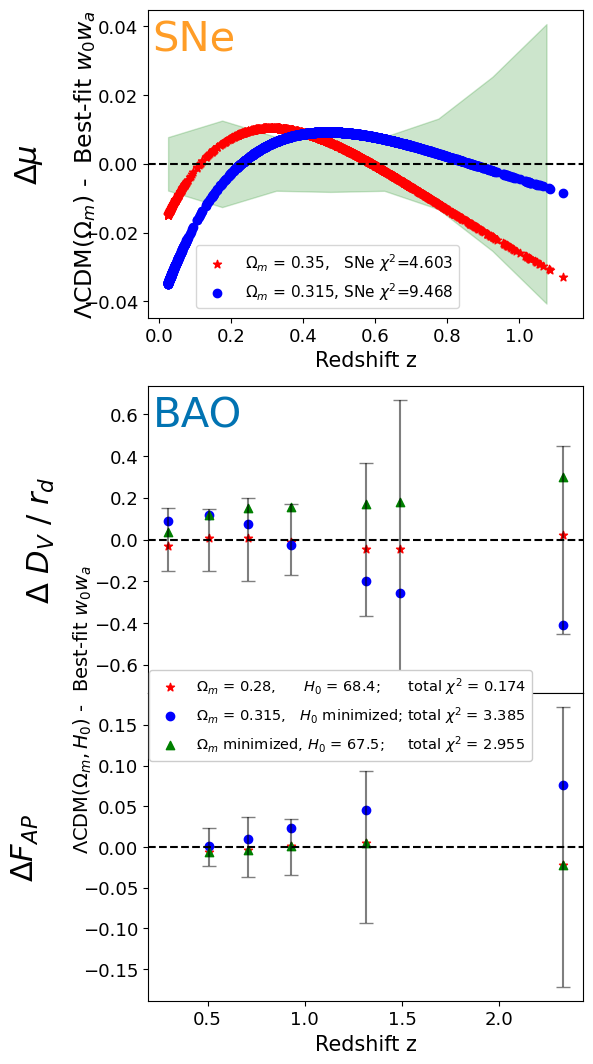

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(6, 11))

gs = gridspec.GridSpec(2, 1, height_ratios=[1, 2])

ax0 = fig.add_subplot(gs[0])

a = chi2(_sne_distmod_under_lcdm - _sne_distmod_under_w0wa)
b = chi2(_sne_distmod_under_planck_lcdm - _sne_distmod_under_w0wa)

ax0.axhline(y=0, color='black', linestyle='--')
ax0.fill_between(bin_centers, (binned_errors - binned_errors - binned_errors),
                 (binned_errors - binned_errors + binned_errors), color='green', alpha=0.2)
ax0.scatter(z_desy5, _sne_distmod_under_lcdm - _sne_distmod_under_w0wa, color='red',
            label=f"$\Omega_m$ = 0.35,   SNe $\chi^2$={a:.3f}", marker='*')
ax0.scatter(z_desy5, _sne_distmod_under_planck_lcdm - _sne_distmod_under_w0wa, color='blue',
            label=f"$\Omega_m$ = 0.315, SNe $\chi^2$={b:.3f}")
ax0.set_xlabel("Redshift z", fontsize=15)
ax0.set_ylabel(r"$\Delta \mu$", fontsize=22, labelpad=27)
ax0.text(-0.145, 0.5, r"$\Lambda$CDM$(\Omega_m)$ -  Best-fit $w_0w_a$",
         fontsize=17, transform=ax0.transAxes, ha='center', va='center', rotation='vertical')
ax0.tick_params(axis='x', labelsize=13)
ax0.tick_params(axis='y', labelsize=13)
ax0.grid(False)
ax0.legend(loc=(0.11, 0.03), fontsize=11)
ax0.text(
    -0.02, 0.033,
    "SNe",
    fontsize=30,
    ha='left',
    color='#ff9d27'
)

gs1 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[1], hspace=0)

ax1 = fig.add_subplot(gs1[0], sharex=None)
ax2 = fig.add_subplot(gs1[1], sharex=ax1)

plt.setp(ax1.get_xticklabels(), visible=False)

ax1.errorbar(zeff_array, _dv_dr_compare - _dv_dr_compare, yerr=delta_dv, fmt='none', capsize=5, alpha=0.5, color='black')
ax1.scatter(zeff_array, _dv_dr_compare - _dv_dr_compare_w0wa, color='red', marker='*')
ax1.scatter(zeff_array, _dv_dr_compare_0315 - _dv_dr_compare_w0wa, color='blue')
ax1.scatter(zeff_array, _dv_dr_compare_h0_different - _dv_dr_compare_w0wa, color='green', marker="^")
ax1.grid(False)
ax1.axhline(y=0, color='black', linestyle='--')

ax1.tick_params(axis='x', labelsize=13)
ax1.tick_params(axis='y', labelsize=13)
ax1.set_ylabel("$\Delta$ $D_V$ / $r_d$", fontsize=22, labelpad=27)
ax1.text(-0.15, -0.05, r"$\Lambda$CDM$(\Omega_m, H_0)$ -  Best-fit $w_0w_a$",
         fontsize=14, transform=ax1.transAxes, ha='center', va='center', rotation='vertical')
ax1.text(
    0.22, 0.54,
    "BAO",
    fontsize=30,
    ha='left',
    color='#0173b2'
)

ax2.errorbar(zeff_fap, _fap_compare - _fap_compare, yerr=delta_fap, fmt='none', capsize=5, alpha=0.5, color='black')
ax2.scatter(zeff_fap, _fap_compare - _fap_compare_w0wa, color='red',
            label=f"$\Omega_m$ = 0.28,      $H_0$ = 68.4;      total $\chi^2$ = {chi2_bao_295:.3f}", marker='*')
ax2.scatter(zeff_fap, _fap_compare_0315 - _fap_compare_w0wa, color='blue',
            label=f"$\Omega_m$ = 0.315,   $H_0$ minimized; total $\chi^2$ = {chi2_bao_315:.3f}")
ax2.scatter(zeff_fap, _fap_compare_h0_different - _fap_compare_w0wa, color='green',
            label=f"$\Omega_m$ minimized, $H_0$ = 67.5;     total $\chi^2$ = {chi2_bao_different_h0:.3f}", marker="^")

ax2.tick_params(axis='x', labelsize=13)
ax2.tick_params(axis='y', labelsize=13)
ax2.set_xlabel("Redshift z", fontsize=15)
ax2.axhline(y=0, color='black', linestyle='--')

ax2.legend()
ax2.set_ylabel("$\Delta F_{AP}$", fontsize=22, labelpad=30)
ax2.text(-0.155, 0.5, r" ",
         fontsize=11, transform=ax2.transAxes, ha='center', va='center', rotation='vertical')

ax2.legend(loc='upper left', bbox_to_anchor=(-0.013, 1.1), framealpha=1, fontsize=10.5)

plt.grid(False)
plt.tight_layout()
plt.savefig('mu_fap_dv_lcdm_w0wabest.png', dpi=600)
plt.show()

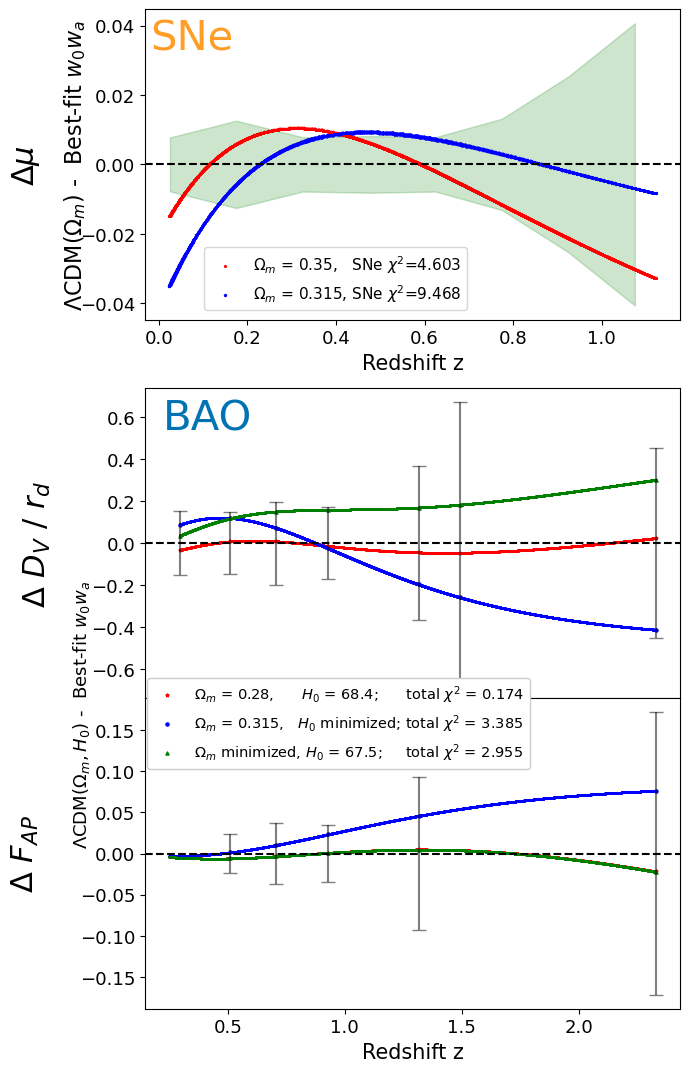

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.gridspec as gridspec


fig = plt.figure(figsize=(7, 11))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 2])

ax0 = fig.add_subplot(gs[0])

a = chi2(_sne_distmod_under_lcdm - _sne_distmod_under_w0wa)
b = chi2(_sne_distmod_under_planck_lcdm - _sne_distmod_under_w0wa)

ax0.axhline(y=0, color='black', linestyle='--')
ax0.fill_between(bin_centers, (binned_errors - binned_errors - binned_errors),
                 (binned_errors - binned_errors + binned_errors), color='green', alpha=0.2)
ax0.scatter(z_desy5, _sne_distmod_under_lcdm - _sne_distmod_under_w0wa, color='red',
            label=f"$\Omega_m$ = 0.35,   SNe $\chi^2$={a:.3f}", marker='*',s=2)
ax0.scatter(z_desy5, _sne_distmod_under_planck_lcdm - _sne_distmod_under_w0wa, color='blue',
            label=f"$\Omega_m$ = 0.315, SNe $\chi^2$={b:.3f}",s=2)

ax0.scatter(z_continous_sne, _sne_distmod_under_lcdm_continuous - _sne_distmod_under_w0wa_continuous, color='red', s=1)
ax0.scatter(z_continous_sne, _sne_distmod_under_planck_lcdm_continuous - _sne_distmod_under_w0wa_continuous, color='blue', s=1)


ax0.set_xlabel("Redshift z", fontsize=15)
ax0.set_ylabel(r"$\Delta \mu$", fontsize=22, labelpad=27)
ax0.text(-0.13, 0.5, r"$\Lambda$CDM$(\Omega_m)$ -  Best-fit $w_0w_a$",
         fontsize=16, transform=ax0.transAxes, ha='center', va='center', rotation='vertical')
ax0.tick_params(axis='x', labelsize=13)
ax0.tick_params(axis='y', labelsize=13)
ax0.grid(False)
ax0.legend(loc=(0.11, 0.03), fontsize=11)
ax0.text(
    -0.02, 0.033,
    "SNe",
    fontsize=30,
    ha='left',
    color='#ff9d27'
)

gs1 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[1], hspace=0)

ax1 = fig.add_subplot(gs1[0], sharex=None)
ax2 = fig.add_subplot(gs1[1], sharex=ax1)

plt.setp(ax1.get_xticklabels(), visible=False)

# Plotting on ax1 (DV / rD comparison)
ax1.errorbar(zeff_array, _dv_dr_compare - _dv_dr_compare, yerr=delta_dv, fmt='none', capsize=5, alpha=0.5, color='black')
ax1.scatter(zeff_array, _dv_dr_compare - _dv_dr_compare_w0wa, color='red', marker='*',s=5)
ax1.scatter(zeff_array, _dv_dr_compare_0315 - _dv_dr_compare_w0wa, color='blue',s=5)
ax1.scatter(zeff_array, _dv_dr_compare_h0_different - _dv_dr_compare_w0wa, color='green', marker="^",s=5)

ax1.scatter(zeff_array_continuous, _dv_dr_compare_continuous - _dv_dr_compare_w0wa_continuous, color='red', s=1)
ax1.scatter(zeff_array_continuous, _dv_dr_compare_0315_continuous - _dv_dr_compare_w0wa_continuous, color='blue', s=1)
ax1.scatter(zeff_array_continuous, _dv_dr_compare_h0_different_continuous - _dv_dr_compare_w0wa_continuous, color='green', s=1)


ax1.grid(False)
ax1.axhline(y=0, color='black', linestyle='--')

ax1.tick_params(axis='x', labelsize=13)
ax1.tick_params(axis='y', labelsize=13)
ax1.set_ylabel("$\Delta$ $D_V$ / $r_d$", fontsize=22, labelpad=28)
ax1.text(-0.118, -0.05, r"$\Lambda$CDM$(\Omega_m, H_0)$ -  Best-fit $w_0w_a$",
         fontsize=13, transform=ax1.transAxes, ha='center', va='center', rotation='vertical')
ax1.text(
    0.22, 0.54,
    "BAO",
    fontsize=30,
    ha='left',
    color='#0173b2'
)

# Plotting on ax2 (FAP comparison)
ax2.errorbar(zeff_fap, _fap_compare - _fap_compare, yerr=delta_fap, fmt='none', capsize=5, alpha=0.5, color='black')
ax2.scatter(zeff_fap, _fap_compare - _fap_compare_w0wa, color='red',
            label=f"$\Omega_m$ = 0.28,      $H_0$ = 68.4;      total $\chi^2$ = {chi2_bao_295:.3f}", marker='*',s=5)
ax2.scatter(zeff_fap, _fap_compare_0315 - _fap_compare_w0wa, color='blue',
            label=f"$\Omega_m$ = 0.315,   $H_0$ minimized; total $\chi^2$ = {chi2_bao_315:.3f}",s=5)
ax2.scatter(zeff_fap, _fap_compare_h0_different - _fap_compare_w0wa, color='green',
            label=f"$\Omega_m$ minimized, $H_0$ = 67.5;     total $\chi^2$ = {chi2_bao_different_h0:.3f}", marker="^",s=5)

ax2.scatter(zeff_fap_continuous, _fap_compare_continuous - _fap_compare_w0wa_continuous, color='red', s=1)
ax2.scatter(zeff_fap_continuous, _fap_compare_0315_continuous - _fap_compare_w0wa_continuous, color='blue', s=1)
ax2.scatter(zeff_fap_continuous, _fap_compare_h0_different_continuous - _fap_compare_w0wa_continuous, color='green', s=1)

ax2.tick_params(axis='x', labelsize=13)
ax2.tick_params(axis='y', labelsize=13)
ax2.set_xlabel("Redshift z", fontsize=15)
ax2.axhline(y=0, color='black', linestyle='--')

ax2.legend()
ax2.set_ylabel("$\Delta\  F_{AP}$", fontsize=22, labelpad=28)
ax2.text(-0.118, 0.5, r" ",
         fontsize=14, transform=ax2.transAxes, ha='center', va='center', rotation='vertical')

ax2.legend(loc='upper left', bbox_to_anchor=(-0.01, 1.09), framealpha=1, fontsize=10.5)

plt.grid(False)
# Adjust layout
plt.tight_layout()
plt.savefig('mu_fap_dv_lcdm_w0wabest.png', dpi=600)
plt.show()

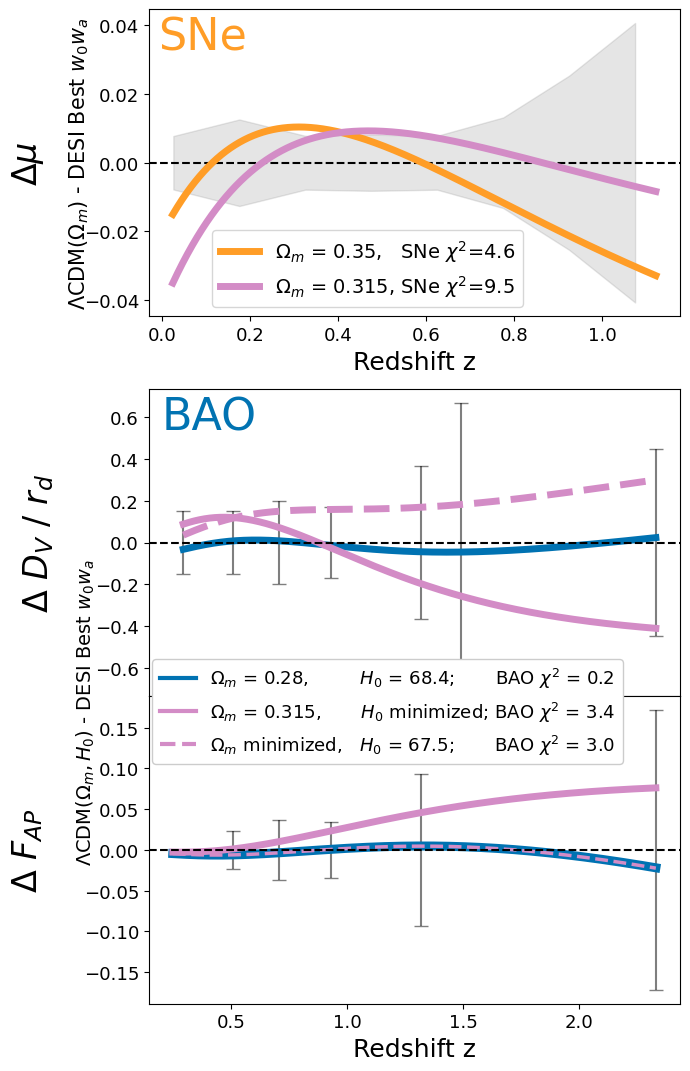

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.gridspec as gridspec


fig = plt.figure(figsize=(7, 11))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 2])
ax0 = fig.add_subplot(gs[0])

a = chi2(_sne_distmod_under_lcdm - _sne_distmod_under_w0wa)
b = chi2(_sne_distmod_under_planck_lcdm - _sne_distmod_under_w0wa)

ax0.axhline(y=0, color='black', linestyle='--')
ax0.fill_between(bin_centers, (binned_errors - binned_errors - binned_errors),
                 (binned_errors - binned_errors + binned_errors), color='grey', alpha=0.2)

ax0.plot(z_continous_sne, _sne_distmod_under_lcdm_continuous - _sne_distmod_under_w0wa_continuous, color='#ff9d27', label=f"$\Omega_m$ = 0.35,   SNe $\chi^2$={a:.1f}",linewidth=5)
ax0.plot(z_continous_sne, _sne_distmod_under_planck_lcdm_continuous - _sne_distmod_under_w0wa_continuous, color='#d38cc6',
            label=f"$\Omega_m$ = 0.315, SNe $\chi^2$={b:.1f}",linewidth=5)


ax0.set_xlabel("Redshift z", fontsize=18)
ax0.set_ylabel(r"$\Delta \mu$", fontsize=24, labelpad=27)
ax0.text(-0.13, 0.5, r"$\Lambda$CDM$(\Omega_m)$ - DESI Best $w_0w_a$",
         fontsize=15, transform=ax0.transAxes, ha='center', va='center', rotation='vertical')
ax0.tick_params(axis='x', labelsize=13)
ax0.tick_params(axis='y', labelsize=13)
ax0.grid(False)
ax0.legend(loc=(0.12, 0.03), fontsize=14)
ax0.text(
    -0.01, 0.033,
    "SNe",
    fontsize=32,
    ha='left',
    color='#ff9d27'
)

gs1 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[1], hspace=0)

ax1 = fig.add_subplot(gs1[0], sharex=None)
ax2 = fig.add_subplot(gs1[1], sharex=ax1)

plt.setp(ax1.get_xticklabels(), visible=False)

ax1.errorbar(zeff_array, _dv_dr_compare - _dv_dr_compare, yerr=delta_dv, fmt='none', capsize=5, alpha=0.5, color='black')
ax1.plot(zeff_array_continuous, _dv_dr_compare_continuous - _dv_dr_compare_w0wa_continuous, color='#0072B2',linewidth=5)
ax1.plot(zeff_array_continuous, _dv_dr_compare_0315_continuous - _dv_dr_compare_w0wa_continuous, color='#d38cc6',linewidth=5)
ax1.plot(zeff_array_continuous, _dv_dr_compare_h0_different_continuous - _dv_dr_compare_w0wa_continuous, color='#d38cc6',linewidth=5,linestyle='--')


ax1.grid(False)
ax1.axhline(y=0, color='black', linestyle='--')

ax1.tick_params(axis='x', labelsize=13)
ax1.tick_params(axis='y', labelsize=13)
ax1.set_ylabel("$\Delta$ $D_V$ / $r_d$", fontsize=24, labelpad=28)
ax1.text(-0.118, -0.05, r"$\Lambda$CDM$(\Omega_m, H_0)$ - DESI Best $w_0w_a$",
         fontsize=14, transform=ax1.transAxes, ha='center', va='center', rotation='vertical')
ax1.text(
    0.2, 0.54,
    "BAO",
    fontsize=32,
    ha='left',
    color='#0173b2'
)

# Plotting on ax2 (FAP comparison)
ax2.errorbar(zeff_fap, _fap_compare - _fap_compare, yerr=delta_fap, fmt='none', capsize=5, alpha=0.5, color='black')

ax2.plot(zeff_fap_continuous, _fap_compare_continuous - _fap_compare_w0wa_continuous,
            color='#0072B2' ,linewidth=6.5)
#ax2.plot(zeff_fap_continuous, _fap_compare_0315_continuous - _fap_compare_w0wa_continuous,
      #      color='blue', alpha=1,linewidth=5)
#ax2.scatter(zeff_fap_continuous, _fap_compare_h0_different_continuous - _fap_compare_w0wa_continuous,
         #   color='green', marker="^", s=10, alpha=0.025)
ax2.plot(zeff_fap_continuous, _fap_compare_0315_continuous - _fap_compare_w0wa_continuous,
            color='#d38cc6', alpha=1,linewidth=5)
ax2.plot(zeff_fap_continuous, _fap_compare_h0_different_continuous - _fap_compare_w0wa_continuous,
         linestyle='--', color='#d38cc6',linewidth=2.5)

ax2.plot([], [], color='#0072B2', label=f"$\Omega_m$ = 0.28,         $H_0$ = 68.4;       BAO $\chi^2$ = {chi2_bao_295:.1f}",linewidth=3)
ax2.plot([], [], color='#d38cc6', label=f"$\Omega_m$ = 0.315,       $H_0$ minimized; BAO $\chi^2$ = {chi2_bao_315:.1f}",linewidth=3)
ax2.plot([], [], color='#d38cc6', linestyle='--',label=f"$\Omega_m$ minimized,   $H_0$ = 67.5;       BAO $\chi^2$ = {chi2_bao_different_h0:.1f}",linewidth=3)


ax2.tick_params(axis='x', labelsize=13)
ax2.tick_params(axis='y', labelsize=13)
ax2.set_xlabel("Redshift z", fontsize=18)
ax2.axhline(y=0, color='black', linestyle='--')

ax2.legend()
ax2.set_ylabel("$\Delta\  F_{AP}$", fontsize=24, labelpad=28)
ax2.text(-0.118, 0.7, r" ",
         fontsize=14, transform=ax2.transAxes, ha='center', va='center', rotation='vertical')

ax2.legend(loc='upper left', bbox_to_anchor=(-0.01, 1.15), framealpha=1, fontsize=13)

plt.grid(False)
plt.tight_layout()
plt.savefig('mu_fap_dv_lcdm_w0wabest.png', dpi=600)
plt.show()